In [2]:
from erddapClient import ERDDAP_Server
import pandas as pd 
import numpy as np


remoteServer = ERDDAP_Server('https://coastwatch.pfeg.noaa.gov/erddap')
remoteServer

<erddapClient.ERDDAP_Server>
Server version:  ERDDAP_version=2.11

In [4]:
# Explore the method allowed arguments
remoteServer.search?

In [3]:
searchRequest = remoteServer.advancedSearch(searchFor="gliders")
searchRequest

<erddapClient.ERDDAP_SearchResults>
Results:  1
[
  0 - <erddapClient.ERDDAP_Tabledap> scrippsGliders , "Gliders, Scripps Institution of Oceanography, 2014-present"
]

In [4]:
# Explore the first result
sgliders = searchRequest[0]
sgliders

<erddapClient.ERDDAP_Tabledap>
Title:       Gliders, Scripps Institution of Oceanography, 2014-present
Server URL:  https://coastwatch.pfeg.noaa.gov/erddap
Dataset ID:  scrippsGliders
Variables: 
  trajectory (String) 
  institution (String) 
  platform_id (String) 
  platform_type (String) 
  wmo_id (int) 
  ctd_make_model (String) 
  segment_id (String) 
  time_uv (double) 
    Standard name: time 
    Units:         seconds since 1970-01-01T00:00:00Z 
  lat_uv (double) 
    Standard name: latitude 
    Units:         degrees_north 
  lon_uv (double) 
    Standard name: longitude 
    Units:         degrees_east 
  u (double) 
    Standard name: eastward_sea_water_velocity 
    Units:         m s-1 
  v (double) 
    Standard name: northward_sea_water_velocity 
    Units:         m s-1 
  uv_qc (byte) 
  profile_id (short) 
  profile_qc (byte) 
  time (double) 
    Standard name: time 
    Units:         seconds since 1970-01-01T00:00:00Z 
  latitude (double) 
    Standard name: lati

In [5]:
# Explore the metadata information
sgliders.global_metadata['summary']

"Spray glider data from Scripps Institution of Oceanography, Instrument Development Group. Gliders are small, free-swimming, unmanned vehicles that use changes in buoyancy to move vertically and horizontally through the water column in a saw-tooth pattern. They are deployed for days to several months and gather detailed information about the physical, chemical and biological processes of the world's oceans."

In [6]:
sgliders.getAttribute('summary')

"Spray glider data from Scripps Institution of Oceanography, Instrument Development Group. Gliders are small, free-swimming, unmanned vehicles that use changes in buoyancy to move vertically and horizontally through the water column in a saw-tooth pattern. They are deployed for days to several months and gather detailed information about the physical, chemical and biological processes of the world's oceans."

In [8]:
# Search glider missions that cover the Gulf of Mexico stream
# Using chained methods technique

sgliders.clearQuery()
missionsInGulf = (
    sgliders.setResultVariables("trajectory")
    .addConstraint("latitude>=17")
    .addConstraint("latitude<=31")
    .addConstraint("longitude>=-98")
    .addConstraint("longitude<=-80")
    .distinct()
    .getDataFrame()  # Request the data and returns a pandas dataframe
)

missionsInGulf


,trajectory
0,sp007-20170427
1,sp010-20150409
2,sp010-20170707
3,sp010-20180620
4,sp022-20170209
5,sp022-20180124
6,sp022-20180912
7,sp055-20150716
8,sp062-20190925
9,sp062-20200227


In [9]:
# Show me the url that was formed to get the data
# By default the library request the data from tabledap in csvp format.
print (sgliders.getDataRequestURL())

https://coastwatch.pfeg.noaa.gov/erddap/tabledap/scrippsGliders.csvp?trajectory&latitude%3E=17&latitude%3C=31&longitude%3E=-98&longitude%3C=-80&distinct()


In [10]:
# Download the data from server 
# We're requesting variables from the gliders trajectories that we searched.

gulfMissions=[]
for idx,row in missionsInGulf.iterrows():
    sgliders.clearQuery()
    print ("Downloading mission: {}".format(row['trajectory']) )
    
    missionData = (
        sgliders.setResultVariables(["time", "trajectory", "latitude", "longitude", "salinity", "temperature"])
        .addConstraint({"trajectory=" : row['trajectory']} )
        .addConstraint("depth<=15")
        .orderByMean("time/1day")
        .getDataFrame(header=0, 
                      names=["time", "trajectory", "latitude", "longitude", "salinity", "temperature"], 
                      parse_dates=["time"],
                      index_col="time")
        # The getDataFrame  method accepts the same parameters as pandas.read_csv
    )
    
    gulfMissions.append(missionData)
    
dfGMissions = pd.concat(gulfMissions)    
dfGMissions

,trajectory,latitude,longitude,salinity,temperature
time,,,,,
2017-04-27 00:00:00+00:00,sp007-20170427,25.920974,-80.025687,36.289103,26.519026
2017-04-28 00:00:00+00:00,sp007-20170427,26.380997,-79.880295,36.277458,26.972917
2017-04-29 00:00:00+00:00,sp007-20170427,27.301759,-79.665314,36.326346,26.840231
2017-04-30 00:00:00+00:00,sp007-20170427,28.399844,-79.874686,36.387682,26.587318
2017-05-01 00:00:00+00:00,sp007-20170427,29.297958,-80.060570,36.387909,25.272886
...,...,...,...,...,...
2019-01-14 00:00:00+00:00,sp069-20181109,35.826130,-74.818216,33.949842,12.236758
2019-01-15 00:00:00+00:00,sp069-20181109,35.810829,-74.859048,33.597071,10.853098
2019-01-16 00:00:00+00:00,sp069-20181109,35.811007,-74.861375,33.742683,11.016346


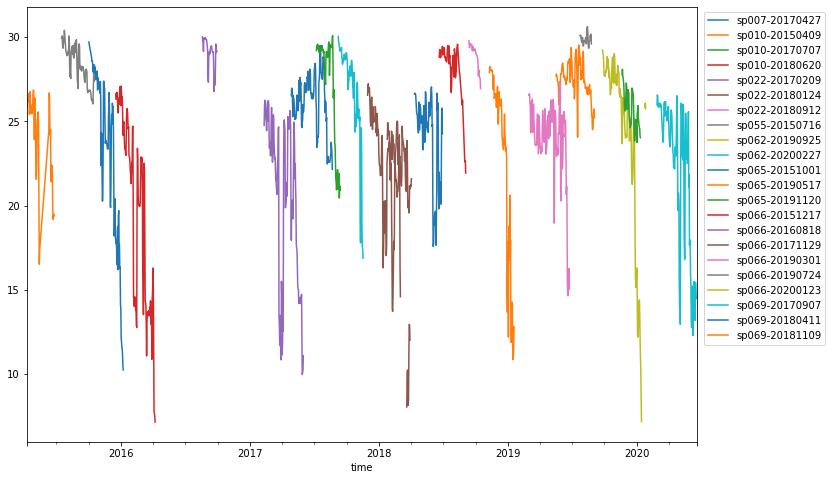

In [12]:
# Plotting libraries
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 8)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import shapely.geometry as sgeom
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


dfGMissions.groupby(['trajectory'])['temperature'].plot(legend=True)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

In [13]:
dfGMissions[dfGMissions['trajectory']=='sp007-20170427']

,trajectory,latitude,longitude,salinity,temperature
time,,,,,
2017-04-27 00:00:00+00:00,sp007-20170427,25.920974,-80.025687,36.289103,26.519026
2017-04-28 00:00:00+00:00,sp007-20170427,26.380997,-79.880295,36.277458,26.972917
2017-04-29 00:00:00+00:00,sp007-20170427,27.301759,-79.665314,36.326346,26.840231
2017-04-30 00:00:00+00:00,sp007-20170427,28.399844,-79.874686,36.387682,26.587318
2017-05-01 00:00:00+00:00,sp007-20170427,29.297958,-80.060570,36.387909,25.272886
...,...,...,...,...,...
2017-08-17 00:00:00+00:00,sp007-20170427,39.349012,-71.911598,33.696621,23.048636
2017-08-18 00:00:00+00:00,sp007-20170427,39.505460,-71.771631,33.498647,23.750412
2017-08-19 00:00:00+00:00,sp007-20170427,39.581074,-71.709186,33.077195,23.432537


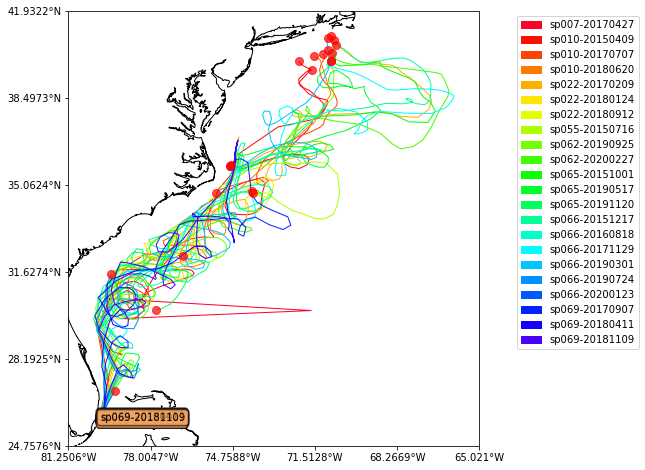

In [14]:
# Plot all mission trajectories

ax = plt.subplot(111, projection=ccrs.PlateCarree())
labelElements = []

for idx,row in missionsInGulf.iterrows():
    mRows = dfGMissions[dfGMissions['trajectory']==row['trajectory']]
    c = plt.cm.gist_rainbow(idx*10)
    
    trajectory = sgeom.LineString(mRows[['longitude','latitude']].values)

    # Trajectory plot as a shapely linestring
    ax.add_geometries([trajectory], ccrs.PlateCarree(), facecolor='none', edgecolor=c, label=row['trajectory'])
    labelElements.append(mpatches.Patch(color=c, label=row['trajectory']))

    # Markers
    plt.plot(mRows['longitude'][0], mRows['latitude'][0], 
             marker='o', color='blue', markersize=8, alpha=0.7)
    plt.plot(mRows['longitude'][-1], mRows['latitude'][-1], 
             marker='o', color='red', markersize=8, alpha=0.7)
    # Mission ID Text
    plt.text(mRows['longitude'][0], mRows['latitude'][0], row['trajectory'],
                 verticalalignment='center', horizontalalignment='left',
                 bbox=dict(facecolor='sandybrown', alpha=0.6, boxstyle='round'))

ax.coastlines(resolution='10m', color='black', linewidth=1)
ax.set_extent([dfGMissions['longitude'].min()-1, dfGMissions['longitude'].max()+1, 
               dfGMissions['latitude'].min()-1, dfGMissions['latitude'].max()+1])
# Coordinate Ticks 
ax.set_xticks(np.linspace(dfGMissions['longitude'].min()-1, dfGMissions['longitude'].max()+1,6) )
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
ax.set_yticks(np.linspace(dfGMissions['latitude'].min()-1, dfGMissions['latitude'].max()+1,6) )
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)

ax.legend(handles=labelElements, loc='upper right', bbox_to_anchor=(1.4, 1))

## Requesting plots from the ERDDAP Server

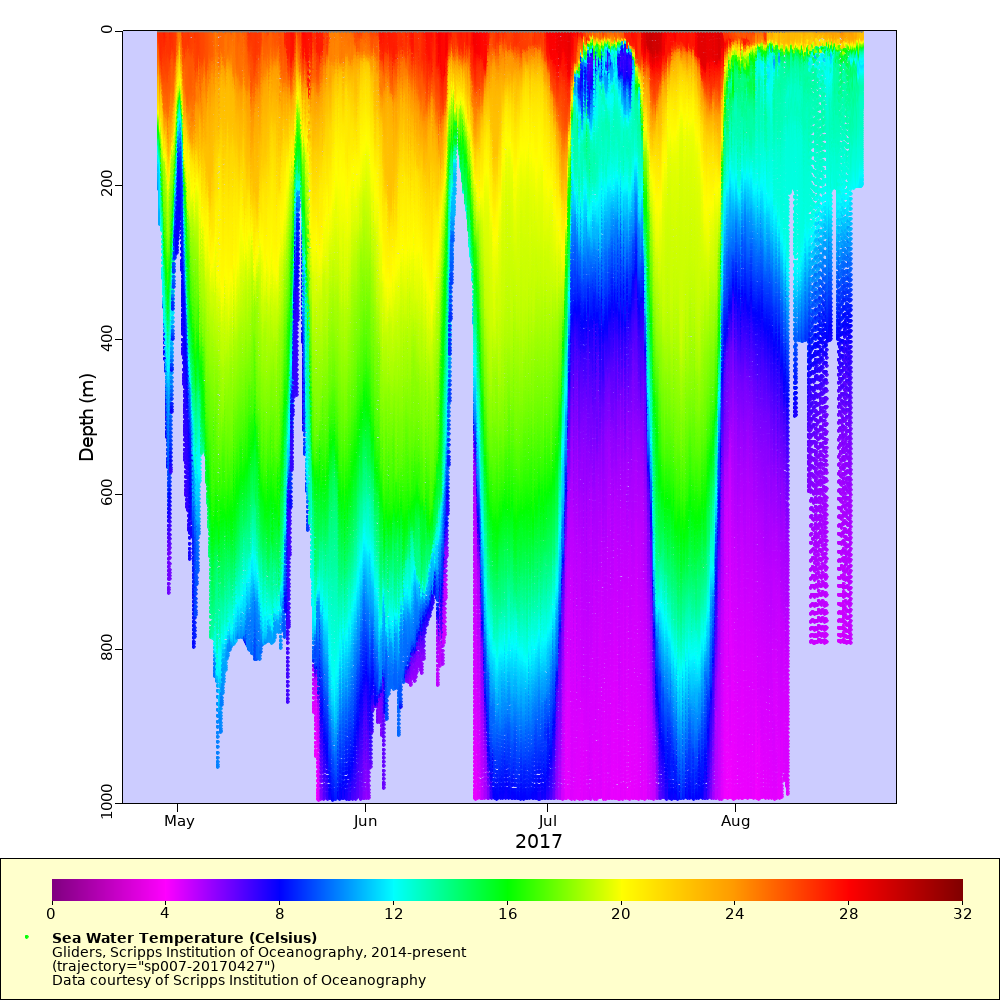

In [17]:
from IPython.display import Image

sgliders.clearQuery()
sideSectionPlot = (
    sgliders.setResultVariables(["time", "depth", "temperature"])
    .addConstraint({"trajectory=" : 'sp007-20170427'} )
    .addConstraint(".draw=markers")
    .addConstraint(".marker=11|2")
    .addConstraint(".yRange=0|1000|false|")
    .addConstraint(".size=1000|1000")
    .addConstraint(".font=1.2")
    .addConstraint(".legend=Bottom")
    .addConstraint(".xRange=|||Linear")
    .addConstraint(".trim=500")    
    .getData('png')
)

Image(data=sideSectionPlot)

# https://coastwatch.pfeg.noaa.gov/erddap/tabledap/scrippsGliders.largePng?
# time,depth,temperature&trajectory=%22sp007-20170427%22&.draw=markers&.marker=1%7C5&
# .color=0x000000&.colorBar=%7C%7C%7C%7C%7C&.bgColor=0xffccccff&.yRange=%7C%7Cfalse%7C

In [18]:
type(sideSectionPlot)

bytes

In [19]:
sgliders.clearQuery()

firstMissionData = (
    sgliders.setResultVariables(["time", "latitude", "longitude", "salinity", "temperature"])
    .addConstraint({"trajectory=" : "sp007-20170427"} )
    .addConstraint("depth<=15")
    .orderByMean("time/1day")
    .getDataFrame(header=0, 
                  names=["time", "latitude", "longitude", "salinity", "temperature"], 
                  parse_dates=["time"],
                  index_col="time")
)

firstMissionData

,latitude,longitude,salinity,temperature
time,,,,
2017-04-27 00:00:00+00:00,25.920974,-80.025687,36.289103,26.519026
2017-04-28 00:00:00+00:00,26.380997,-79.880295,36.277458,26.972917
2017-04-29 00:00:00+00:00,27.301759,-79.665314,36.326346,26.840231
2017-04-30 00:00:00+00:00,28.399844,-79.874686,36.387682,26.587318
2017-05-01 00:00:00+00:00,29.297958,-80.060570,36.387909,25.272886
...,...,...,...,...
2017-08-17 00:00:00+00:00,39.349012,-71.911598,33.696621,23.048636
2017-08-18 00:00:00+00:00,39.505460,-71.771631,33.498647,23.750412
2017-08-19 00:00:00+00:00,39.581074,-71.709186,33.077195,23.432537


<AxesSubplot:xlabel='time'>

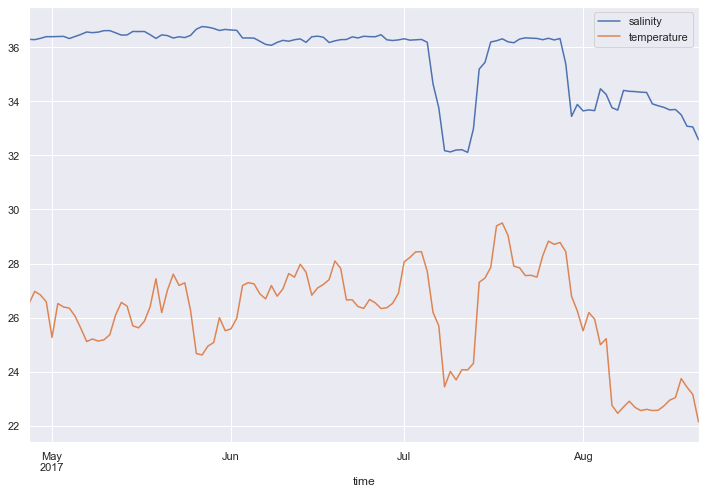

In [20]:
import seaborn as sns
sns.set()
sns.set(rc={'figure.figsize':(12,8)})

firstMissionData.plot(y=["salinity", "temperature"])

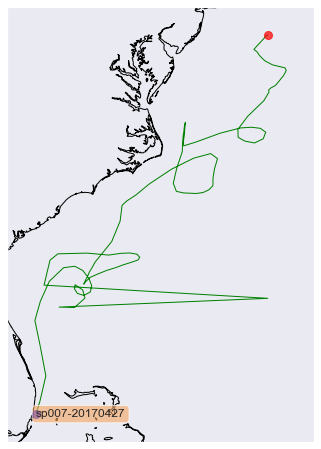

In [21]:
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
import cartopy.crs as ccrs

ax = plt.subplot(111, projection=ccrs.PlateCarree())

trajectory = sgeom.LineString(firstMissionData[['longitude','latitude']].values)

# Trajectory
ax.add_geometries([trajectory], ccrs.PlateCarree(), facecolor='none', edgecolor='green')

# Markers
plt.plot(firstMissionData['longitude'][0], firstMissionData['latitude'][0], 
         marker='o', color='blue', markersize=8, alpha=0.7)
plt.plot(firstMissionData['longitude'][-1], firstMissionData['latitude'][-1], 
         marker='o', color='red', markersize=8, alpha=0.7)
plt.text(firstMissionData['longitude'][0], firstMissionData['latitude'][0], u'sp007-20170427',
             verticalalignment='center', horizontalalignment='left',
             bbox=dict(facecolor='sandybrown', alpha=0.6, boxstyle='round'))

ax.coastlines(resolution='10m', color='black', linewidth=1)
ax.set_extent([firstMissionData['longitude'].min()-1, firstMissionData['longitude'].max()+1, 
               firstMissionData['latitude'].min()-1, firstMissionData['latitude'].max()+1])
